1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
# from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [7]:
type(trainset.data)

torch.Tensor

In [8]:
type(trainset.targets)

torch.Tensor

In [9]:
print('Original dataset shape %s' % collections.Counter(trainset.targets.tolist()))


Original dataset shape Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [10]:
class unbalance_FashionMNIST(FashionMNIST):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_FashionMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
     
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 600,
                1: 6000,
                2: 600,
                3: 6000,
                4: 600,
                5: 6000,
                6: 600,
                7: 6000,
                8: 600,
                9: 6000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(60000,28*28), np.array(self.targets))
        self.data, self.targets = torch.Tensor(self.data.reshape(-1,28,28)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)



In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [12]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 6000, 3: 6000, 5: 6000, 7: 6000, 9: 6000, 0: 600, 2: 600, 4: 600, 6: 600, 8: 600})


In [13]:
trainset.class_to_idx


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [14]:
idx2class = {v: k for k, v in trainset.class_to_idx.items()}
print(idx2class)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [15]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [16]:
print("Distribution of classes: \n", get_class_distribution(trainset))

Distribution of classes: 
 {'T-shirt/top': 600, 'Trouser': 6000, 'Pullover': 600, 'Dress': 6000, 'Coat': 600, 'Sandal': 6000, 'Shirt': 600, 'Sneaker': 6000, 'Bag': 600, 'Ankle boot': 6000}


In [17]:
target_list = torch.tensor(trainset.targets)
print(target_list)

tensor([0, 0, 0,  ..., 9, 9, 9], dtype=torch.uint8)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [18]:
target_list = target_list[torch.randperm(len(target_list))]


In [19]:
class_count = [i for i in get_class_distribution(trainset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0017, 0.0002, 0.0017, 0.0002, 0.0017, 0.0002, 0.0017, 0.0002, 0.0017,
        0.0002])


In [20]:
class_weights_all = [class_weights[int(t)] for t in target_list]
print(class_weights_all)

[tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0017), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(

In [21]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=weighted_sampler,
                                          shuffle=False, num_workers= 8 ,pin_memory= True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)



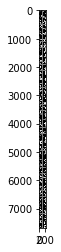

Dress Sneaker Ankle boot Dress


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(1, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1024, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1024, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [26]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.348
[2,    10] loss: 0.531
[3,    10] loss: 0.355
[4,    10] loss: 0.273
[5,    10] loss: 0.219
[6,    10] loss: 0.185
[7,    10] loss: 0.172
[8,    10] loss: 0.153
[9,    10] loss: 0.130
[10,    10] loss: 0.115
[11,    10] loss: 0.114
[12,    10] loss: 0.110
[13,    10] loss: 0.092
[14,    10] loss: 0.095
[15,    10] loss: 0.085
[16,    10] loss: 0.086
[17,    10] loss: 0.077
[18,    10] loss: 0.076
[19,    10] loss: 0.079
[20,    10] loss: 0.066
[21,    10] loss: 0.064
[22,    10] loss: 0.066
[23,    10] loss: 0.062
[24,    10] loss: 0.055
[25,    10] loss: 0.056
[26,    10] loss: 0.055
[27,    10] loss: 0.058
[28,    10] loss: 0.051
[29,    10] loss: 0.052
[30,    10] loss: 0.052
[31,    10] loss: 0.049
[32,    10] loss: 0.048
[33,    10] loss: 0.052
[34,    10] loss: 0.045
[35,    10] loss: 0.042
[36,    10] loss: 0.043
[37,    10] loss: 0.047
[38,    10] loss: 0.042
[39,    10] loss: 0.038
[40,    10] loss: 0.033
[41,    10] loss: 0.037
[42,    10] loss: 0.038
[

In [ ]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:  Sandal  Coat Shirt Shirt Sneaker Pullover Sandal   Bag Dress Sneaker Shirt Dress Pullover T-shirt/top Ankle boot Shirt Shirt   Bag Sandal Pullover Dress   Bag  Coat Sneaker Pullover Dress   Bag Dress  Coat  Coat T-shirt/top Pullover  Coat Sneaker Trouser Dress Ankle boot Ankle boot  Coat T-shirt/top Pullover Ankle boot Sneaker Dress Ankle boot T-shirt/top Dress Trouser Shirt Trouser Pullover Shirt Ankle boot Trouser Pullover T-shirt/top Ankle boot Ankle boot Sandal  Coat Trouser Ankle boot  Coat Dress


In [28]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [29]:
net.train()
outputs = net(images)

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  Sandal Shirt Shirt Shirt Sneaker Pullover Sandal   Bag Dress Sneaker Shirt Dress Pullover T-shirt/top Ankle boot T-shirt/top Dress   Bag Sandal Trouser Dress   Bag  Coat Sneaker Dress Dress   Bag Dress Shirt Dress Dress Pullover Trouser Sneaker Trouser Dress Ankle boot Ankle boot  Coat T-shirt/top Pullover Ankle boot Sneaker Dress Ankle boot T-shirt/top Dress Trouser Shirt Trouser Pullover Dress Ankle boot Trouser Pullover T-shirt/top Ankle boot Ankle boot Sandal Dress Trouser Ankle boot  Coat Dress Shirt T-shirt/top Sandal Sneaker Sneaker T-shirt/top Sandal Sandal Dress Pullover Dress Dress   Bag Sneaker Pullover Ankle boot Trouser Dress Sandal Pullover T-shirt/top Sneaker Dress Trouser Sneaker Sandal Shirt T-shirt/top Sneaker   Bag Ankle boot Dress Sandal Ankle boot Pullover Shirt Pullover Trouser T-shirt/top Ankle boot Ankle boot Dress Pullover   Bag  Coat T-shirt/top T-shirt/top Sneaker T-shirt/top Shirt  Coat Sneaker T-shirt/top Dress Trouser Sandal Shirt Dress Dress A

In [31]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


In [32]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class T-shirt/top is: 78.2 %
Accuracy for class Trouser is: 98.6 %
Accuracy for class Pullover is: 84.2 %
Accuracy for class Dress is: 98.0 %
Accuracy for class Coat  is: 79.2 %
Accuracy for class Sandal is: 98.6 %
Accuracy for class Shirt is: 63.0 %
Accuracy for class Sneaker is: 98.2 %
Accuracy for class Bag   is: 95.5 %
Accuracy for class Ankle boot is: 96.7 %


In [33]:
for i in range(10):
    print(classes[labels[i]])

Dress
Ankle boot
Sneaker
Dress
Shirt
Coat
Sneaker
Coat
Pullover
Dress
